In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, split, explode, array, regexp_replace, length, expr

In [4]:
spark = SparkSession.Builder().appName('DDAM_Project_Mushrooms').getOrCreate()
sql_ctx = SQLContext(spark)

mushroom_df = spark.read.options(inferSchema = True, delimiter = ';', header = True).csv('dataset/secondary_data.csv')

In [ ]:
mushroom_df.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

In [ ]:
mushroom_df.dtypes

[('class', 'string'),
 ('cap-diameter', 'double'),
 ('cap-shape', 'string'),
 ('cap-surface', 'string'),
 ('cap-color', 'string'),
 ('does-bruise-or-bleed', 'string'),
 ('gill-attachment', 'string'),
 ('gill-spacing', 'string'),
 ('gill-color', 'string'),
 ('stem-height', 'double'),
 ('stem-width', 'double'),
 ('stem-root', 'string'),
 ('stem-surface', 'string'),
 ('stem-color', 'string'),
 ('veil-type', 'string'),
 ('veil-color', 'string'),
 ('has-ring', 'string'),
 ('ring-type', 'string'),
 ('spore-print-color', 'string'),
 ('habitat', 'string'),
 ('season', 'string')]

Missing Values

In [ ]:
missing = mushroom_df.select([count(when(isnull(c), c)).alias(c) for c in mushroom_df.columns])
missing.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    0|           0|        0|      14120|        0|                   0|           9884|       25063|         0|          0|         0|    51538|       38124|         0|    57892|     53656|       0|     2471|            54715|      0|     0|
+-----+------------+----

Attributes with too many missing values that we will probably exclude from the other analyses:

stem-root: 51538/61069 null values

stem-surface: 38124/61069 null values

veil-type:  57892/61069 (+ only a class "u")

veil-color: 53656/61069 null values

spore-print-color: 54715/61069 null values

gill-spacing? 25063

In [ ]:
mushroom_df.show()

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

In [ ]:
mushroom_df.count()

61069

Discrete attribute analysis

In [ ]:
cat_cols = [element[0] for element in mushroom_df.dtypes if element[1] == 'string']
print('The numerical columns are')
print(cat_cols)

The numerical columns are
['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [ ]:
for c in cat_cols:
    print(f'column {c} contains {len(mushroom_df.select(c).distinct().collect())} distinct values')

column class contains 2 distinct values
column cap-shape contains 7 distinct values
column cap-surface contains 12 distinct values
column cap-color contains 12 distinct values
column does-bruise-or-bleed contains 2 distinct values
column gill-attachment contains 8 distinct values
column gill-spacing contains 4 distinct values
column gill-color contains 12 distinct values
column stem-root contains 6 distinct values
column stem-surface contains 9 distinct values
column stem-color contains 13 distinct values
column veil-type contains 2 distinct values
column veil-color contains 7 distinct values
column has-ring contains 2 distinct values
column ring-type contains 9 distinct values
column spore-print-color contains 8 distinct values
column habitat contains 8 distinct values
column season contains 4 distinct values


In [ ]:
for c in cat_cols:
  print(f'column {c} distinct values are: ')
  results = mushroom_df.select(c).distinct().collect()

  results_string = ''
  for row in results:
    results_string += f"{str(row[c])} "
  print(results_string)
  print()

column class distinct values are: 
e p 

column cap-shape distinct values are: 
x f o p c b s 

column cap-surface distinct values are: 
l g k e h d y w i t s None 

column cap-color distinct values are: 
l g n k e o p w y u b r 

column does-bruise-or-bleed distinct values are: 
f t 

column gill-attachment distinct values are: 
x f e p d a s None 

column gill-spacing distinct values are: 
f d c None 

column gill-color distinct values are: 
g f n k e o p w y u b r 

column stem-root distinct values are: 
f c b r s None 

column stem-surface distinct values are: 
g f k h y i t s None 

column stem-color distinct values are: 
l g f n k e o p w y u b r 

column veil-type distinct values are: 
u None 

column veil-color distinct values are: 
n k e w y u None 

column has-ring distinct values are: 
f t 

column ring-type distinct values are: 
l g m f e z p r None 

column spore-print-color distinct values are: 
g n k p w u r None 

column habitat distinct values are: 
l g m h p d w u 

c

In [ ]:
for c in cat_cols:
  print(f'column {c} distinct values counts are: ')
  mushroom_df.groupBy(c).count().orderBy('count', ascending=False).show()

column class distinct values counts are: 
+-----+-----+
|class|count|
+-----+-----+
|    p|33888|
|    e|27181|
+-----+-----+

column cap-shape distinct values counts are: 
+---------+-----+
|cap-shape|count|
+---------+-----+
|        x|26934|
|        f|13404|
|        s| 7164|
|        b| 5694|
|        o| 3460|
|        p| 2598|
|        c| 1815|
+---------+-----+

column cap-surface distinct values counts are: 
+-----------+-----+
|cap-surface|count|
+-----------+-----+
|       NULL|14120|
|          t| 8196|
|          s| 7608|
|          y| 6341|
|          h| 4974|
|          g| 4724|
|          d| 4432|
|          e| 2584|
|          k| 2303|
|          i| 2225|
|          w| 2150|
|          l| 1412|
+-----------+-----+

column cap-color distinct values counts are: 
+---------+-----+
|cap-color|count|
+---------+-----+
|        n|24218|
|        y| 8543|
|        w| 7666|
|        g| 4420|
|        e| 4035|
|        o| 3656|
|        r| 1782|
|        u| 1709|
|        p| 170

Categorical variables bar plot

In [ ]:
mushroom_df.createOrReplaceTempView("Mushrooms_Data")

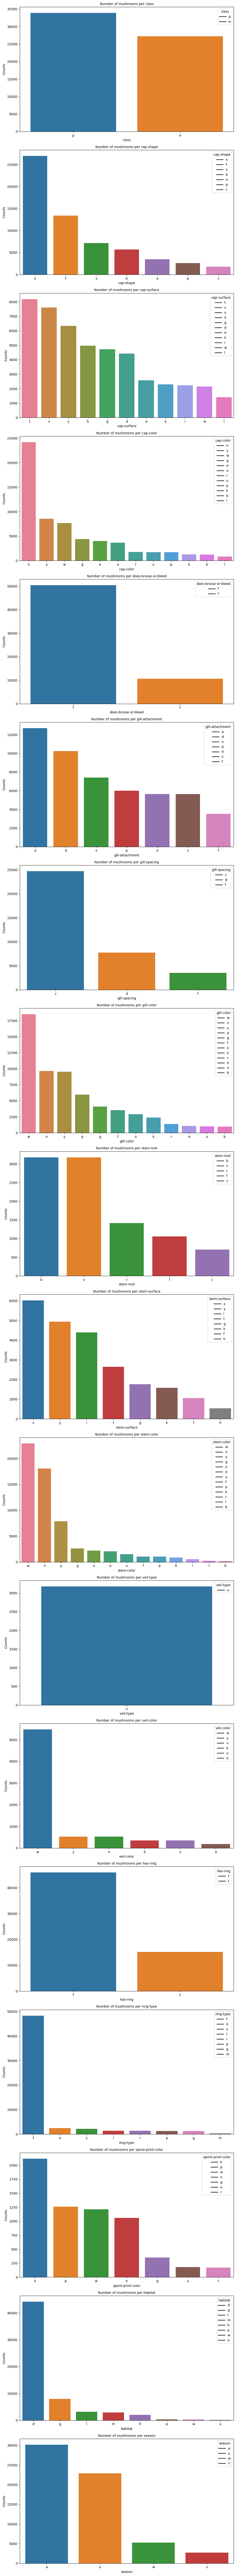

In [ ]:
fig, axs = plt.subplots(len(cat_cols), figsize=(10, 6*len(cat_cols)))

for i, col in enumerate(cat_cols):
    col_counts = spark.sql(f"SELECT `{col}`, COUNT(*) as count FROM Mushrooms_Data WHERE `{col}` IS NOT NULL GROUP BY `{col}`").toPandas()
    col_counts = col_counts.sort_values(by='count', ascending=False)
    sns.barplot(x=col, y="count", hue=col, data=col_counts, ax=axs[i])
    axs[i].set_xlabel(col, size=10)
    axs[i].set_ylabel("Counts", size=10)
    axs[i].set_title(f"Number of mushrooms per {col}", size=10)
    unique_col_values = col_counts[col].unique()
    axs[i].legend(title=col, labels=unique_col_values)

plt.tight_layout()
plt.show()

Continuous attribute analysis

In [ ]:
num_cols = [element[0] for element in mushroom_df.dtypes if element[1] != 'string']
print('The numerical columns are')
print(num_cols)

The numerical columns are
['cap-diameter', 'stem-height', 'stem-width']


In [ ]:
mushroom_df.select(num_cols).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
cap-diameter,61069,6.733854492459317,5.264844947062989,0.38,62.34
stem-height,61069,6.581538260001019,3.3700168612896366,0.0,33.92
stem-width,61069,12.149410011626177,10.03595504311756,0.0,103.91


>>> plotting distribution for cap-diameter


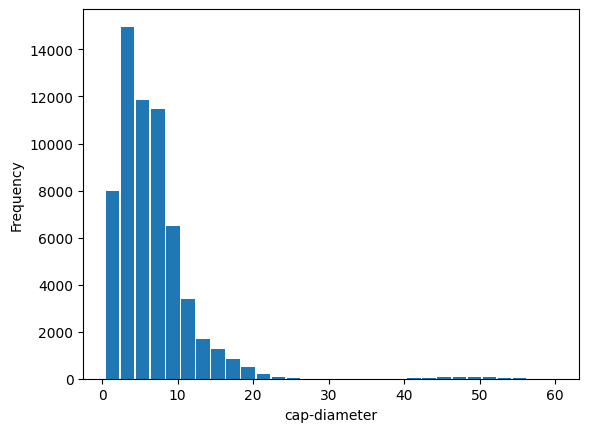

>>> plotting distribution for stem-height


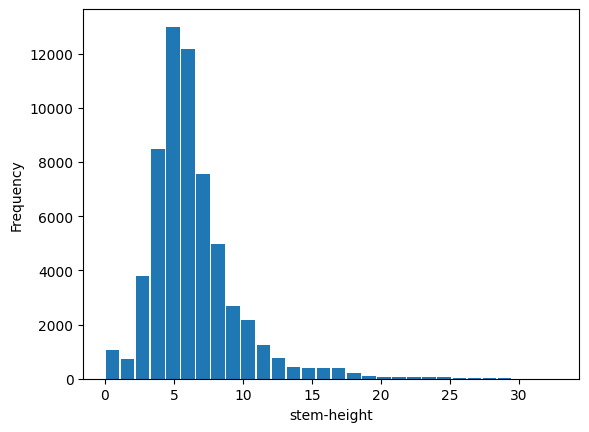

>>> plotting distribution for stem-width


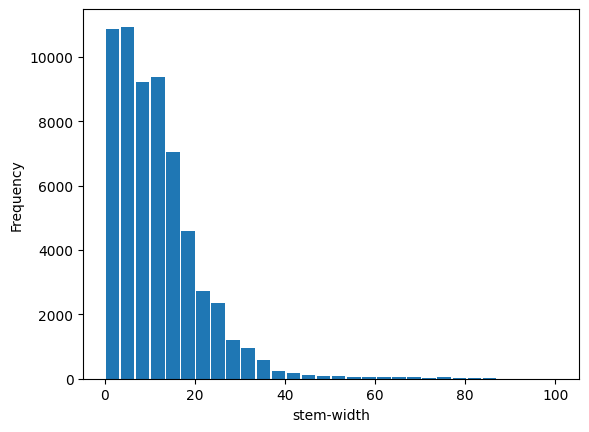

In [ ]:
for col in num_cols:
    print(f">>> plotting distribution for {col}")
    query = spark.sql(f'SELECT `{col}` FROM Mushrooms_Data')
    h = query.select(col).rdd.flatMap(lambda x: x).histogram(30)
    dfh = pd.DataFrame(
        list(zip(*h)),
        columns=['bin', 'frequency']
    )
    bins = dfh['bin']
    counts = dfh['frequency']
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    plt.show()

Outlier detection

In [139]:
mushroom_df_sample = mushroom_df.sample(withReplacement = False, fraction = 0.05, seed=42)
mushroom_df_sample_df = mushroom_df_sample.toPandas()

<Axes: xlabel='cap-diameter', ylabel='stem-height'>

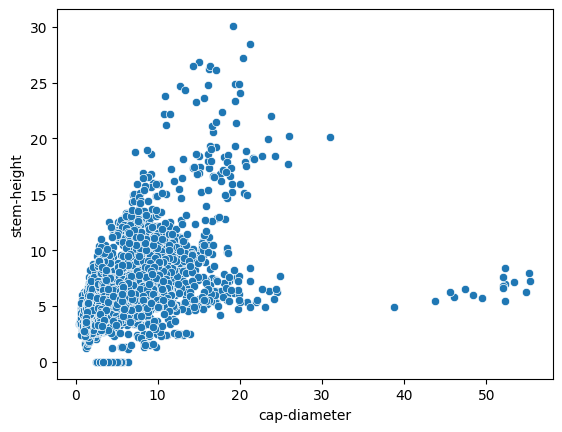

In [140]:
sns.scatterplot(data=mushroom_df_sample_df, x='cap-diameter', y='stem-height')

<Axes: xlabel='cap-diameter', ylabel='stem-width'>

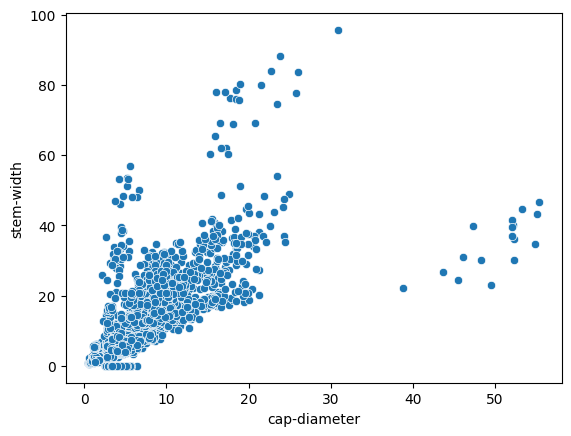

In [141]:
sns.scatterplot(data=mushroom_df_sample_df, x='cap-diameter', y='stem-width')

<Axes: xlabel='stem-width', ylabel='stem-height'>

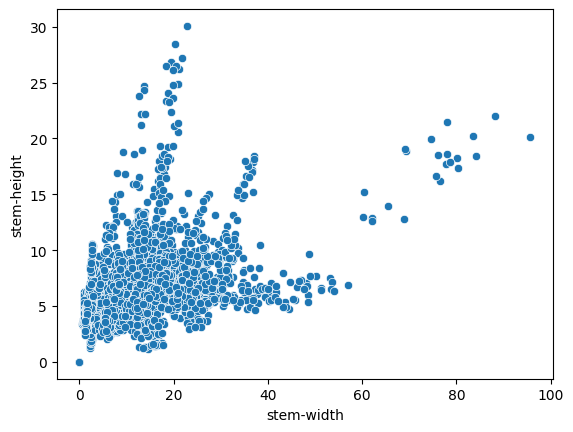

In [142]:
sns.scatterplot(data=mushroom_df_sample_df, x='stem-width', y='stem-height')

Scatter plot colored by categorical attributes

class 
'cap-shape', 'cap-surface' (ha null), 'cap-color', 'does-bruise-or-bleed', 'gill-attachment' (ha null), 'gill-spacing' (riserva), 'gill-color',  'stem-color', ('stem-surface', 'veil-type', 'veil-color', 'spore-print-color', vedere se i pochi esempi non nulli sono outlier) 'has-ring', 'ring-type' (ha null),  'habitat', 'season'

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(mushroom_df_sample_df['stem-width'], mushroom_df_sample_df['stem-height'], mushroom_df_sample_df['cap-diameter'], color = "green")
plt.title("3D scatter plot")

3D-Scatterplot

Correlation matrix

In [143]:
vectorassembler = VectorAssembler(inputCols = num_cols, outputCol= 'numericalfeatures')
output_dataset = vectorassembler.transform(mushroom_df)

In [144]:
pearson = Correlation.corr(output_dataset, 'numericalfeatures', 'pearson').collect()[0][0]
correlation_array = pearson.toArray() 

correlation_df = pd.DataFrame(
    correlation_array,
    index = num_cols,
    columns = num_cols
)

correlation_df

,cap-diameter,stem-height,stem-width
cap-diameter,1.00000,0.422560,0.695330
stem-height,0.42256,1.000000,0.436117
stem-width,0.69533,0.436117,1.000000


<Axes: >

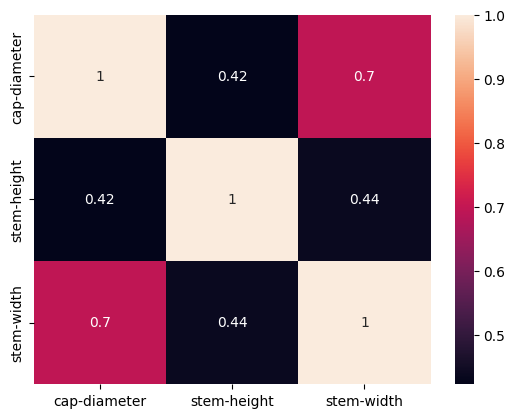

In [145]:
sns.heatmap(correlation_df, annot=True)

In [146]:
spearman = Correlation.corr(output_dataset, 'numericalfeatures', 'spearman').collect()[0][0]
correlation_array = spearman.toArray() 

correlation_df = pd.DataFrame(
    correlation_array,
    index = num_cols,
    columns = num_cols
)

correlation_df

24/05/21 19:39:15 WARN Executor: Managed memory leak detected; size = 17072486 bytes, task 0.0 in stage 646.0 (TID 490)
24/05/21 19:39:15 WARN Executor: Managed memory leak detected; size = 17072486 bytes, task 0.0 in stage 652.0 (TID 492)


,cap-diameter,stem-height,stem-width
cap-diameter,1.000000,0.552516,0.863215
stem-height,0.552516,1.000000,0.501270
stem-width,0.863215,0.501270,1.000000


<Axes: >

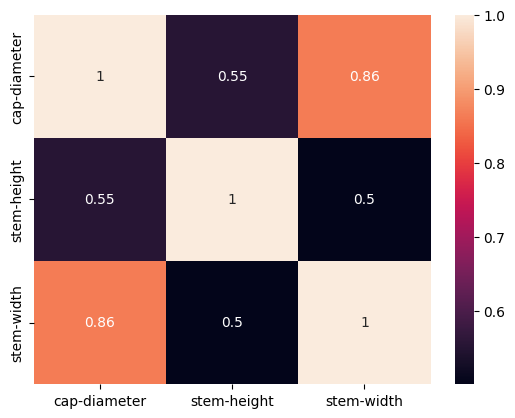

In [147]:
sns.heatmap(correlation_df, annot=True)

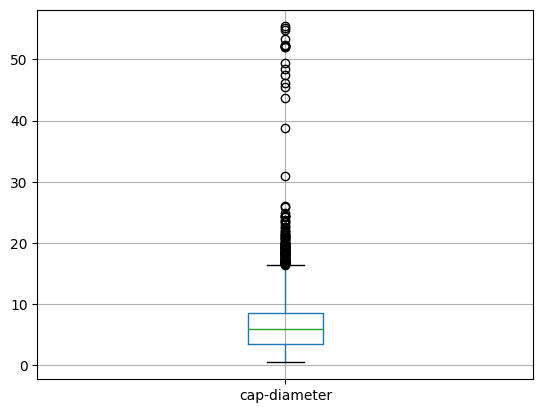

Whiskers:  [3.45, 0.48, 8.64, 16.39]
Median:  5.89


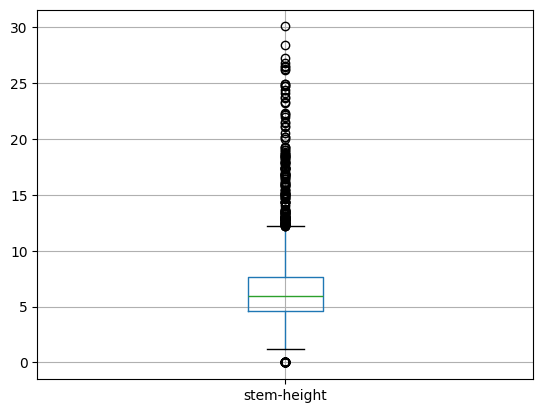

Whiskers:  [4.64, 1.19, 7.672499999999999, 12.2]
Median:  5.925


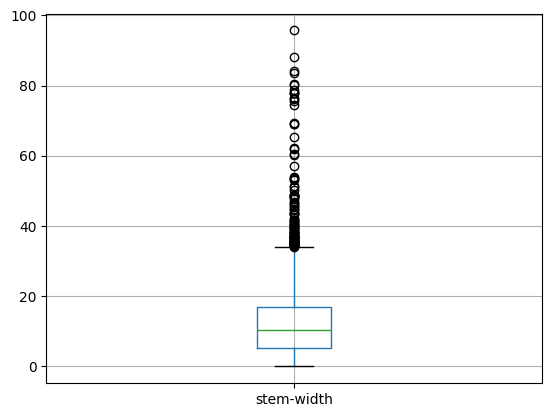

Whiskers:  [5.36, 0.0, 16.8425, 34.01]
Median:  10.33


In [148]:
for col in num_cols:
    plot = mushroom_df_sample.toPandas().boxplot(column=col, return_type = 'dict')
    plt.show()
    
    whisker_values = []
    for whisker in plot['whiskers']:
        whisker_values.extend(whisker.get_ydata())
    print('Whiskers: ', whisker_values)
    print('Median: ', plot['medians'][0].get_ydata()[0])
    



In [149]:
# from primary dataset
cap_diameter_real_min = 0.4
cap_diameter_real_max = 30

stem_height_real_min =  0
stem_height_real_max = 35

stem_width_real_min =  0
stem_width_real_max =  100

In [150]:
cleaned_df = spark.sql(f"SELECT `cap-diameter`,`stem-height`, `stem-width` FROM Mushrooms_Data WHERE `cap-diameter`>= {cap_diameter_real_min} AND `cap-diameter`<= {cap_diameter_real_max} AND `stem-height`>= {stem_height_real_min} AND `stem-height`<= {stem_height_real_max} AND `stem-width`>= {stem_width_real_min} AND `stem-width`<= {stem_width_real_max}")
cleaned_df.toPandas()


,cap-diameter,stem-height,stem-width
0,15.26,16.95,17.09
1,16.60,17.99,18.19
2,14.07,17.80,17.74
3,14.17,15.77,15.98
4,14.64,16.53,17.20
...,...,...,...
60704,1.18,3.93,6.22
60705,1.27,3.18,5.43
60706,1.27,3.86,6.37
60707,1.24,3.56,5.44


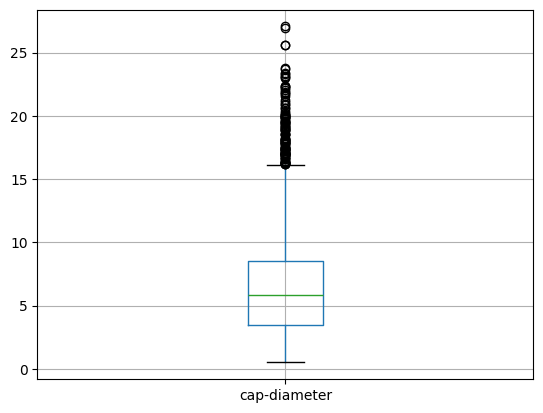

Whiskers:  [3.44, 0.51, 8.515, 16.12]
Median:  5.85


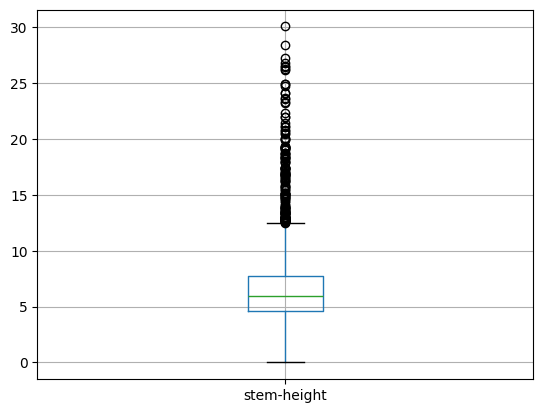

Whiskers:  [4.64, 0.0, 7.76, 12.44]
Median:  5.93


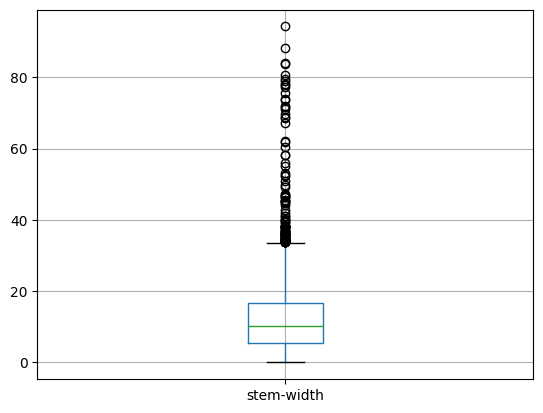

Whiskers:  [5.36, 0.0, 16.67, 33.41]
Median:  10.15


In [151]:
cleaned_mushroom_df_sample = cleaned_df.sample(withReplacement = False, fraction = 0.05, seed=42)
for col in num_cols:
    plot = cleaned_mushroom_df_sample.toPandas().boxplot(column=col, return_type = 'dict')
    plt.show()
    
    whisker_values = []
    for whisker in plot['whiskers']:
        whisker_values.extend(whisker.get_ydata())
    print('Whiskers: ', whisker_values)
    print('Median: ', plot['medians'][0].get_ydata()[0])

In [152]:
outlier_error_df = spark.sql(f"SELECT `cap-diameter`,`stem-height`, `stem-width` FROM Mushrooms_Data WHERE NOT (`cap-diameter`>= {cap_diameter_real_min} AND `cap-diameter`<= {cap_diameter_real_max} AND `stem-height`>= {stem_height_real_min} AND `stem-height`<= {stem_height_real_max} AND `stem-width`>= {stem_width_real_min} AND `stem-width`<= {stem_width_real_max})")
outlier_error_df.count()

360

In [163]:
cap_diameter_df = cleaned_df.filter(cleaned_df['cap-diameter'] > 16.12)
stem_height_df = cleaned_df.filter(cleaned_df['stem-height'] > 12.44)
stem_width_df = cleaned_df.filter(cleaned_df['stem-width'] > 33.41)
outlier_df = cleaned_df.filter((cleaned_df['cap-diameter'] > 16.12) & (cleaned_df['stem-height'] > 12.44) & (cleaned_df['stem-width'] > 33.41))


In [162]:
print(cap_diameter_df.count())
print(stem_height_df.count())
print(stem_width_df.count())
print(outlier_df.count())

2041
3118
1815
520


TODO
- Giustificare perchè eliminiamo gli outlier attraverso la distribuzione delle classi e dei valori nulli